# Name: Margaret Nguyen

# Machine Learning: Principal Component Analysis (PCA) and Ordinary Least Squares (OLS)

In [34]:
# Import packages
import numpy as np # v 1.21.5
import sklearn # v 1.0.2
import pandas as pd # v 1.4.4
import ydata_profiling as pp # v 3.6.6
import statsmodels.api as sm # v 0.13.2

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Ploting libraries 
import matplotlib
#matplotlib.use('Qt5Agg')  # Use an appropriate backend like 'Qt5Agg' for GUI display
import matplotlib.pyplot as plt # v 3.5.2
import seaborn as sns # v 0.11.2
# Display any generated plots or visualizations directly in the notebook interface
%matplotlib inline 

### I. Data Cleaning and Manipulation

In [35]:
# Read the csv file 
df_pa_bna = pd.read_csv('./data/df_pa_crash.csv')

# Read the csv file 
df_mass_bna = pd.read_csv('./data/df_mass_bna.csv', low_memory=False)

**Clean the Pennsylvania crash dataset**

In [36]:
# Clean datasets
df_pa_bna.drop(columns = ['Unnamed: 0'], inplace=True)

# Select columns with numeric data types (int or float) using select_dtypes
numeric_columns = df_pa_bna.select_dtypes(include=['number'])

# Create a new DataFrame with only the numeric columns
df_pa_crash = df_pa_bna[numeric_columns.columns]

# Drop unnessary columns
df_pa_crash = df_pa_crash.drop(['PENN_DOT_MUNI_ID', 'state', 'county', 'county_subdivision', 'LAND_AREA.1', 'LAND_AREA', 'PENN_DOT_COUNTY_NUM', 'FEDERAL_EIN_CODE', 'HOME_RULE_YEAR', 'INCORPORATION_YEAR', 'MUNICIPALITY'], axis=1)

# Replace NaN values with 0 in the entire DataFrame
df_pa_crash = df_pa_crash.fillna(0)

# Rename BNA Score column to BNA_SCORE column
df_pa_crash.rename(columns={'BNA Score': 'BNA_SCORE'}, inplace=True)

# Reset index
df_pa_crash.reset_index(inplace = True, drop = True)

In [37]:
# Define the columns for which you want to calculate per capita values
columns_to_convert = [
    'BIKE_TO_WORK_EST', 'BIKE_TO_WORK_MARG',
    'WALK_TO_WORK_EST', 'WALK_TO_WORK_MARG', 'DRIVE_SOLO_TO_WORK_EST',
    'DRIVE_SOLO_TO_WORK_MARG', 'CARPOOL_TO_WORK_EST',
    'CARPOOL_TO_WORK_MARG', 'PUBTRANS_TO_WORK_EST',
    'PUBTRANS_TO_WORK_MARG', 'EMPLOYEES_FULL_TIME',
    'EMPLOYEES_PART_TIME', 'AUTOMOBILE_COUNT',
    'BICYCLE_BY_AUTO_COUNT', 'BICYCLE_DEATH_BY_AUTO_COUNT',
    'BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT', 'PED_BY_AUTO_COUNT',
    'PED_DEATH_BY_AUTO_COUNT', 'PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT',
    'BICYCLE_SOLO_COUNT', 'BICYCLE_DEATH_SOLO_COUNT',
    'BICYCLE_SUSP_SERIOUS_INJ_SOLO_COUNT', 'PED_SOLO_COUNT',
    'PED_DEATH_SOLO_COUNT', 'PED_SUSP_SERIOUS_INJ_SOLO_COUNT'
]

# Create new columns with "_PER_CAPITA" suffix by dividing each column by 'POPULATION'
for column in columns_to_convert:
    new_column_name = column + '_PER_CAPITA'
    df_pa_crash[new_column_name] = df_pa_crash[column] / df_pa_crash['POPULATION']

**Clean the Massachusett crash dataset**

In [38]:
# Clean datasets
df_mass_bna.drop(columns = ['Unnamed: 0'], inplace=True)

# Exclude the NaN from 'VEHC_CONFIG_CL'
df_mass_crash = df_mass_bna[df_mass_bna['VEHC_CONFIG_CL'].notna()]

# List of NOT automobiles: Snowmobile, Moped, Motorcycle, Other Light Trucks (10,000 lbs., or Less), Other e.g. Farm Equipment, Unknown.
# Exclude the non-automobiles from 'VEHC_CONFIG_CL' columns
list_non_automobiles = ['V1:(Unknown vehicle configuration)', 'V1:(Other e.g. farm equipment)', 'V1:(Unknown vehicle configuration) / V2:(Unknown vehicle configuration)']
df_mass_crash= df_mass_crash[~df_mass_crash['VEHC_CONFIG_CL'].isin(list_non_automobiles)]

In [39]:
# Fatal - injuries that resulted in death 
# Incapacitating - serious injuries require immediate medical attention

## BICYCLE_DEATH_BY_AUTO_COUNT
# Filter the DataFrame for cyclist fatalities
cyclist_fatalities = df_mass_crash[(df_mass_crash['INJY_STAT_DESCR'] == 'Fatal injury (K)') & (df_mass_crash['NON_MTRST_TYPE_CL'] == 'Cyclist')]

# Group the filtered DataFrame by 'CITY_TOWN_NAME' and calculate the count for each city
bicycle_death_counts = cyclist_fatalities.groupby('CITY_TOWN_NAME').size().reset_index(name='BICYCLE_DEATH_BY_AUTO_COUNT')

# Merge the bicycle_death_counts DataFrame into df_mass_crash on 'CITY_TOWN_NAME'
df_mass_crash = df_mass_crash.merge(bicycle_death_counts, on='CITY_TOWN_NAME', how='left')

## BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT
cyclist_incapacitating = df_mass_crash[(df_mass_crash['INJY_STAT_DESCR'] == 'Non-fatal injury - Incapacitating') & (df_mass_crash['NON_MTRST_TYPE_CL'] == 'Cyclist')]
bicycle_sus_serious_inj_counts = cyclist_incapacitating.groupby('CITY_TOWN_NAME').size().reset_index(name='BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT')

# Merge the bicycle_sus_serious_inj_counts DataFrame into df_mass_crash on 'CITY_TOWN_NAME'
df_mass_crash = df_mass_crash.merge(bicycle_sus_serious_inj_counts, on='CITY_TOWN_NAME', how='left')

# Replace NaN values with 0 in the specified columns
df_mass_crash['BICYCLE_DEATH_BY_AUTO_COUNT'].fillna(0, inplace=True)
df_mass_crash['BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT'].fillna(0, inplace=True)

## BICYCLE_BY_AUTO_COUNT
df_mass_crash['BICYCLE_BY_AUTO_COUNT'] = df_mass_crash['BICYCLE_DEATH_BY_AUTO_COUNT'] + df_mass_crash['BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT']

## AUTOMOBILE_COUNT
auto_count = df_mass_crash.groupby('CITY_TOWN_NAME')['NUMB_VEHC'].sum().reset_index()
auto_count.rename(columns={'NUMB_VEHC': 'AUTOMOBILE_COUNT'}, inplace=True)
# Merge the auto_count into df_mass_crash on 'CITY_TOWN_NAME'
df_mass_crash = df_mass_crash.merge(auto_count, on='CITY_TOWN_NAME', how='left')

## PED_DEATH_BY_AUTO_COUNT
# Filter the DataFrame for pedestrian fatalities
ped_fatalities = df_mass_crash[(df_mass_crash['INJY_STAT_DESCR'] == 'Fatal injury (K)') & (df_mass_crash['NON_MTRST_TYPE_CL'] == 'Pedestrian')]

# Group the filtered DataFrame by 'CITY_TOWN_NAME' and calculate the count for each city
ped_death_counts = cyclist_fatalities.groupby('CITY_TOWN_NAME').size().reset_index(name='PED_DEATH_BY_AUTO_COUNT')

# Merge the ped_death_counts DataFrame into df_mass_crash on 'CITY_TOWN_NAME'
df_mass_crash = df_mass_crash.merge(ped_death_counts, on='CITY_TOWN_NAME', how='left')

## PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT
ped_incapacitating = df_mass_crash[(df_mass_crash['INJY_STAT_DESCR'] == 'Non-fatal injury - Incapacitating') & (df_mass_crash['NON_MTRST_TYPE_CL'] == 'Pedestrian')]
ped_sus_serious_inj_counts = ped_incapacitating.groupby('CITY_TOWN_NAME').size().reset_index(name='PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT')

# Merge the ped_sus_serious_inj_counts DataFrame into df_mass_crash on 'CITY_TOWN_NAME'
df_mass_crash = df_mass_crash.merge(ped_sus_serious_inj_counts, on='CITY_TOWN_NAME', how='left')

# Replace NaN values with 0 in the specified columns
df_mass_crash['PED_DEATH_BY_AUTO_COUNT'].fillna(0, inplace=True)
df_mass_crash['PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT'].fillna(0, inplace=True)

##PED_BY_AUTO_COUNT
df_mass_crash['PED_BY_AUTO_COUNT'] = df_mass_crash['PED_DEATH_BY_AUTO_COUNT'] + df_mass_crash['PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT']

# Drop the duplicated rows
df_mass_crash = df_mass_crash.drop_duplicates(subset=['CITY_TOWN_NAME', 'BNA Score', 'POPULATION', 
                                                      'BIKE_TO_WORK_EST', 'BICYCLE_BY_AUTO_COUNT', 
                                                      'BICYCLE_DEATH_BY_AUTO_COUNT', 
                                                      'BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT', 
                                                      'AUTOMOBILE_COUNT', 'PED_BY_AUTO_COUNT', 
                                                      'PED_DEATH_BY_AUTO_COUNT', 'PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT'])

In [40]:
# Select columns with numeric data types (int or float) using select_dtypes
numeric_columns = df_mass_crash.select_dtypes(include=['number'])

# Create a new DataFrame with only the numeric columns
df_mass_crash = df_mass_crash[numeric_columns.columns]

# Rename BNA Score column to BNA_SCORE column
df_mass_crash.rename(columns={'BNA Score': 'BNA_SCORE'}, inplace=True)

# Reset index
df_mass_crash.reset_index(drop = True, inplace = True)

In [41]:
# Define the columns for which you want to calculate per capita values
columns_to_convert = [
    'BIKE_TO_WORK_EST', 'BIKE_TO_WORK_MARG',
    'WALK_TO_WORK_EST', 'WALK_TO_WORK_MARG', 'DRIVE_SOLO_TO_WORK_EST',
    'DRIVE_SOLO_TO_WORK_MARG', 'CARPOOL_TO_WORK_EST',
    'CARPOOL_TO_WORK_MARG', 'PUBTRANS_TO_WORK_EST',
    'PUBTRANS_TO_WORK_MARG', 'AUTOMOBILE_COUNT',
    'BICYCLE_BY_AUTO_COUNT', 'BICYCLE_DEATH_BY_AUTO_COUNT',
    'BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT', 'PED_BY_AUTO_COUNT',
    'PED_DEATH_BY_AUTO_COUNT', 'PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT']

# Create new columns with "_PER_CAPITA" suffix by dividing each column by 'POPULATION'
for column in columns_to_convert:
    new_column_name = column + '_PER_CAPITA'
    df_mass_crash[new_column_name] = df_mass_crash[column] / df_mass_crash['POPULATION']

**Create dumnmy variable for each dataframe**

In [42]:
df_pa_crash['penn'] = 1
df_mass_crash['penn'] = 0

In [43]:
# Drop columns that df_mass_crash does not have
drop_columns = ['EMPLOYEES_FULL_TIME', 'EMPLOYEES_PART_TIME', 'BICYCLE_SOLO_COUNT', 'BICYCLE_DEATH_SOLO_COUNT', 'BICYCLE_SUSP_SERIOUS_INJ_SOLO_COUNT', 'PED_SOLO_COUNT', 'PED_DEATH_SOLO_COUNT', 'PED_SUSP_SERIOUS_INJ_SOLO_COUNT', 'EMPLOYEES_FULL_TIME_PER_CAPITA', 'EMPLOYEES_PART_TIME_PER_CAPITA', 'BICYCLE_SOLO_COUNT_PER_CAPITA', 'BICYCLE_DEATH_SOLO_COUNT_PER_CAPITA', 'BICYCLE_SUSP_SERIOUS_INJ_SOLO_COUNT_PER_CAPITA', 'PED_SOLO_COUNT_PER_CAPITA', 'PED_DEATH_SOLO_COUNT_PER_CAPITA', 'PED_SUSP_SERIOUS_INJ_SOLO_COUNT_PER_CAPITA']
df_pa_crash = df_pa_crash.drop(columns=drop_columns)

# Reorder the columns of the df_mass_crash to match df_pa_crash
df_mass_crash = df_mass_crash[df_pa_crash.columns]

In [44]:
# Print the shape of each datadrame
df_mass_crash.shape, df_pa_crash.shape

((45, 37), (44, 37))

In [45]:
df_crash_bna = pd.concat([df_pa_crash, df_mass_crash], axis=0)
# Reset index
df_crash_bna.reset_index(drop = True, inplace = True)

# Show merge dataframe
df_crash_bna.head()

,POPULATION,BIKE_TO_WORK_EST,BIKE_TO_WORK_MARG,WALK_TO_WORK_EST,WALK_TO_WORK_MARG,DRIVE_SOLO_TO_WORK_EST,DRIVE_SOLO_TO_WORK_MARG,CARPOOL_TO_WORK_EST,CARPOOL_TO_WORK_MARG,PUBTRANS_TO_WORK_EST,...,PUBTRANS_TO_WORK_EST_PER_CAPITA,PUBTRANS_TO_WORK_MARG_PER_CAPITA,AUTOMOBILE_COUNT_PER_CAPITA,BICYCLE_BY_AUTO_COUNT_PER_CAPITA,BICYCLE_DEATH_BY_AUTO_COUNT_PER_CAPITA,BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT_PER_CAPITA,PED_BY_AUTO_COUNT_PER_CAPITA,PED_DEATH_BY_AUTO_COUNT_PER_CAPITA,PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT_PER_CAPITA,penn
0,125250,79,51,2396,607,36549,1464,8407,817,2039,...,0.016279,0.003162,0.002443,0.000383,0.0,0.000032,0.001964,0.000016,0.000232,1
1,44114,4,6,761,210,14943,816,1391,269,508,...,0.011516,0.004738,0.001065,0.000204,0.0,0.000023,0.000816,0.000023,0.000113,1
2,3268,0,11,0,11,1397,231,109,79,11,...,0.003366,0.005202,0.000306,0.000000,0.0,0.000000,0.000306,0.000000,0.000000,1
3,4438,0,11,75,56,1404,197,108,64,0,...,0.000000,0.002479,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1
4,1600,0,11,25,14,686,125,76,52,0,...,0.000000,0.006875,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1


In [46]:
# Check for the shape of the datafrane
df_crash_bna.shape

(89, 37)

In [47]:
# Check for NaN missing values
df_crash_bna.isna().sum()

POPULATION                                           0
BIKE_TO_WORK_EST                                     0
BIKE_TO_WORK_MARG                                    0
WALK_TO_WORK_EST                                     0
WALK_TO_WORK_MARG                                    0
DRIVE_SOLO_TO_WORK_EST                               0
DRIVE_SOLO_TO_WORK_MARG                              0
CARPOOL_TO_WORK_EST                                  0
CARPOOL_TO_WORK_MARG                                 0
PUBTRANS_TO_WORK_EST                                 0
PUBTRANS_TO_WORK_MARG                                0
AUTOMOBILE_COUNT                                     0
BICYCLE_BY_AUTO_COUNT                                0
BICYCLE_DEATH_BY_AUTO_COUNT                          0
BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT               0
PED_BY_AUTO_COUNT                                    0
PED_DEATH_BY_AUTO_COUNT                              0
PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT                   0
BNA_SCORE 

**Use Pandas Profiling**

In [48]:
#pp.ProfileReport(df_crash_bna)

### II. Principal Component Analysis (PCA)

In [49]:
df_crash_filtered = df_crash_bna.copy()

# Drop the binary column while running the PCA
df_crash_filtered.drop(columns='penn', inplace=True)

In [50]:
# Normalize the features
crash_scaler = StandardScaler()
crash_std = crash_scaler.fit_transform(df_crash_filtered)

In [51]:
#create a function to display the explained Variance related to principle components
def Number_of_Principle_Components(X_standardized,n_components):
    #Dimensionality reduction 
    # conduct principle compenent analysis on the data and examine the explained variance of the components
    from sklearn.decomposition import PCA
    sklearn_pca = PCA(n_components=n_components)
    Y_sklearn = sklearn_pca.fit_transform(X_standardized)
    pca = sklearn_pca.fit_transform(crash_std)
    plt.plot(sklearn_pca.explained_variance_ratio_)
    plt.show()
    print(
        'The percentage of total variance in the dataset explained by each',
        'component from Sklearn PCA.\n',
        sklearn_pca.explained_variance_ratio_
    )

    explained_variance = []
    explained_variance = sklearn_pca.explained_variance_ratio_

    total_variace = 0
    total_variace = 0
    components = 0
    num_prints = 0
    print('\n')
    for v in explained_variance:
        total_variace+=v
        components +=1

        if total_variace>=0.5 and total_variace<0.7 and num_prints < 1 :
            print(" to retain {}% of total variance  {} components are required".format(round(100*total_variace,2),components))
            num_prints+=1

        if total_variace>=0.7 and total_variace<0.8 and num_prints < 2 :
            print(" to retain {}% of total variance {} components required".format(round(100*total_variace,2),components))
            num_prints+=1

        elif total_variace>=0.8 and total_variace<0.9 and num_prints < 3 :
            print(" to retain {}% of total variance {} components required".format(round(100*total_variace,2),components))
            num_prints+=1

        elif total_variace>=0.9 and num_prints < 4  :
            print(" to retain {}% of total variance {} components required".format(round(100*total_variace,2),components))
            num_prints+=1

        else:
            None

    print(sum(explained_variance))

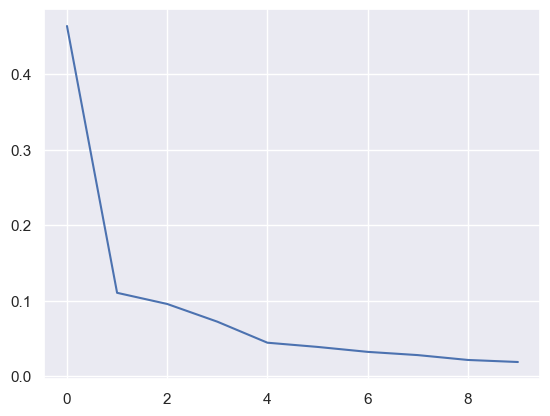

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.46384332 0.1103408  0.09554958 0.07210912 0.04423065 0.03865072
 0.03209299 0.02781894 0.02137695 0.01865636]


 to retain 57.42% of total variance  2 components are required
 to retain 74.18% of total variance 4 components required
 to retain 82.47% of total variance 6 components required
 to retain 90.6% of total variance 9 components required
0.9246694348465445


In [52]:
Number_of_Principle_Components(crash_std,10)

In [53]:
n_components=6
pca = PCA(n_components)
crash_pca_components = pca.fit_transform(crash_std)
print(crash_pca_components)

[[ 2.11091277e+00 -8.74376414e-01 -1.82368404e+00  2.37580378e+00
  -1.91829661e+00  4.95847607e-01]
 [-5.74200175e-01 -5.70492733e-01 -1.16116972e+00  8.23501712e-01
  -1.63323328e-01 -1.42686642e-01]
 [-2.33610653e+00 -1.88024014e+00  1.04777285e+00 -5.27586080e-01
   5.51329833e-01  3.38974559e-01]
 [-1.95004351e+00 -4.79380090e-01  6.46635053e-01 -3.01133153e-01
   8.56865500e-01  2.61587150e-01]
 [-2.55954306e+00 -1.56531471e+00  2.38764918e+00 -2.50443958e-01
   3.54877192e-01  1.03386300e+00]
 [-1.51500031e-02 -2.53765795e-01 -1.18413498e+00  7.31171030e-01
  -7.23863893e-01 -3.18668561e-01]
 [-2.15520723e+00 -1.19768666e+00  1.92564959e+00  5.18100830e-01
   5.08847592e-01  2.45291037e+00]
 [-1.57623286e+00 -3.67189050e-01  1.99358383e-01  2.20076747e+00
   1.14688074e+00  4.86965966e-01]
 [-3.01898904e-01  2.16799366e+00 -4.76725265e-01  3.69559769e+00
  -8.26300879e-02 -1.17034604e+00]
 [-1.23444468e+00 -1.50768299e+00 -9.86343087e-01 -8.85442770e-02
   4.50195278e-01  6.5376

In [54]:
df_crash_filtered[["PCA1", "PCA2", "PCA3", "PCA4", "PCA5", "PCA6"]] = crash_pca_components[:]
df_crash_filtered[["PCA1","PCA2","PCA3","PCA4","PCA5","PCA6"]].head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6
0,2.110913,-0.874376,-1.823684,2.375804,-1.918297,0.495848
1,-0.574200,-0.570493,-1.161170,0.823502,-0.163323,-0.142687
2,-2.336107,-1.880240,1.047773,-0.527586,0.551330,0.338975
3,-1.950044,-0.479380,0.646635,-0.301133,0.856866,0.261587
4,-2.559543,-1.565315,2.387649,-0.250444,0.354877,1.033863


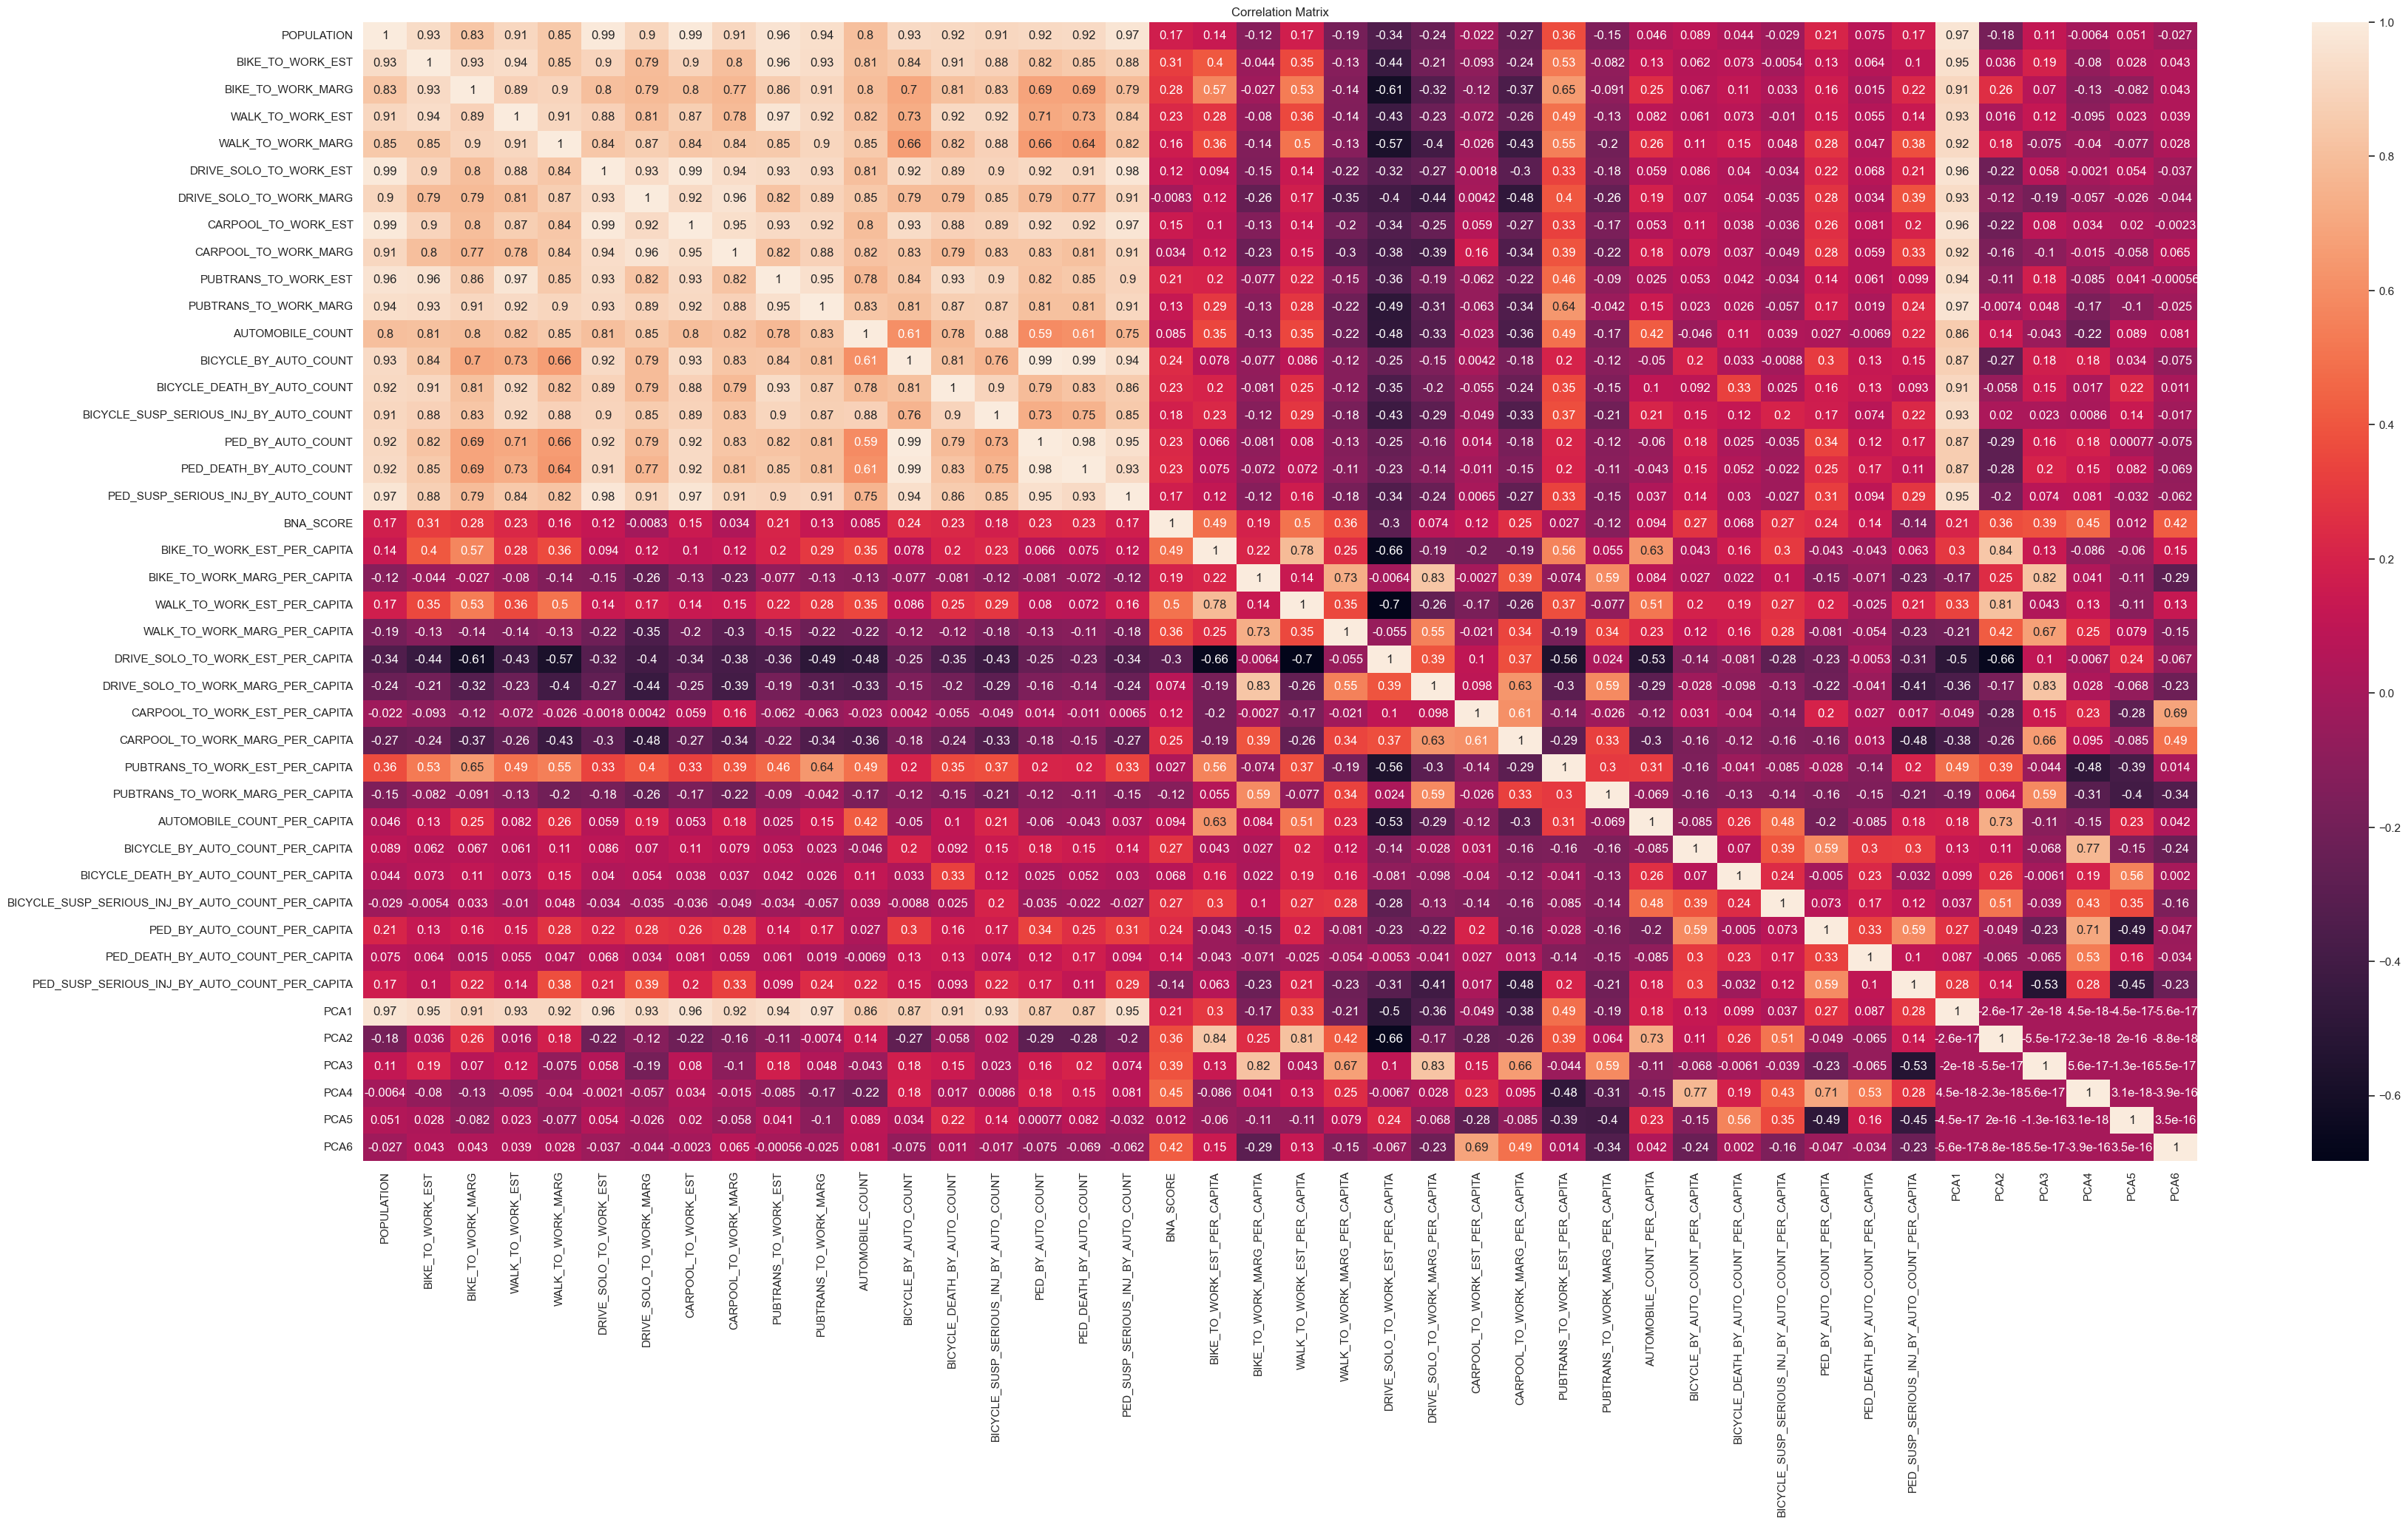

In [55]:
# Create heatmap
heat_corr = df_crash_filtered[['POPULATION', 'BIKE_TO_WORK_EST', 'BIKE_TO_WORK_MARG',
       'WALK_TO_WORK_EST', 'WALK_TO_WORK_MARG', 'DRIVE_SOLO_TO_WORK_EST',
       'DRIVE_SOLO_TO_WORK_MARG', 'CARPOOL_TO_WORK_EST',
       'CARPOOL_TO_WORK_MARG', 'PUBTRANS_TO_WORK_EST', 'PUBTRANS_TO_WORK_MARG',
       'AUTOMOBILE_COUNT', 'BICYCLE_BY_AUTO_COUNT',
       'BICYCLE_DEATH_BY_AUTO_COUNT', 'BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT',
       'PED_BY_AUTO_COUNT', 'PED_DEATH_BY_AUTO_COUNT',
       'PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT', 'BNA_SCORE',
       'BIKE_TO_WORK_EST_PER_CAPITA', 'BIKE_TO_WORK_MARG_PER_CAPITA',
       'WALK_TO_WORK_EST_PER_CAPITA', 'WALK_TO_WORK_MARG_PER_CAPITA',
       'DRIVE_SOLO_TO_WORK_EST_PER_CAPITA',
       'DRIVE_SOLO_TO_WORK_MARG_PER_CAPITA', 'CARPOOL_TO_WORK_EST_PER_CAPITA',
       'CARPOOL_TO_WORK_MARG_PER_CAPITA', 'PUBTRANS_TO_WORK_EST_PER_CAPITA',
       'PUBTRANS_TO_WORK_MARG_PER_CAPITA', 'AUTOMOBILE_COUNT_PER_CAPITA',
       'BICYCLE_BY_AUTO_COUNT_PER_CAPITA',
       'BICYCLE_DEATH_BY_AUTO_COUNT_PER_CAPITA',
       'BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT_PER_CAPITA',
       'PED_BY_AUTO_COUNT_PER_CAPITA', 'PED_DEATH_BY_AUTO_COUNT_PER_CAPITA',
       'PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT_PER_CAPITA', 'PCA1', 'PCA2', 'PCA3',
       'PCA4', 'PCA5', 'PCA6']].corr()

plt.figure(figsize=(40,20))
sns.set(rc={ 'figure.facecolor':'w'})
sns.heatmap(heat_corr, annot=True) 
plt.title("Correlation Matrix")
plt.show()

In [56]:
# Add PCA components into the dataframe
df_crash_bna[["PCA1", "PCA2", "PCA3", "PCA4", "PCA5", "PCA6"]] = crash_pca_components[:]

In [57]:
# Check to see of the BNA score has a strong correlation with PCAs.
df_crash_bna[['BNA_SCORE', 'PCA1', 'PCA2',
       'PCA3', 'PCA4', 'PCA5', 'PCA6']].corr()

,BNA_SCORE,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6
BNA_SCORE,1.000000,2.086123e-01,3.646793e-01,3.896075e-01,4.536612e-01,1.190360e-02,4.177641e-01
PCA1,0.208612,1.000000e+00,-2.573198e-17,-1.975145e-18,4.547243e-18,-4.451314e-17,-5.641697e-17
PCA2,0.364679,-2.573198e-17,1.000000e+00,-5.467015e-17,-2.330804e-18,2.016269e-16,-8.754973e-18
PCA3,0.389608,-1.975145e-18,-5.467015e-17,1.000000e+00,5.635624e-17,-1.313889e-16,5.530906e-17
PCA4,0.453661,4.547243e-18,-2.330804e-18,5.635624e-17,1.000000e+00,3.067828e-18,-3.931612e-16
PCA5,0.011904,-4.451314e-17,2.016269e-16,-1.313889e-16,3.067828e-18,1.000000e+00,3.465395e-16
PCA6,0.417764,-5.641697e-17,-8.754973e-18,5.530906e-17,-3.931612e-16,3.465395e-16,1.000000e+00


**According to the correlation table, we should incorporate BNA Score into the PCA to avoid multicollinearity and add it to the model because it does not exhibit a strong correlation with the PCAs.**

In [58]:
# Create the table to visualize the correlations
df_crash_filtered[['POPULATION', 'BIKE_TO_WORK_EST', 'BIKE_TO_WORK_MARG',
       'WALK_TO_WORK_EST', 'WALK_TO_WORK_MARG', 'DRIVE_SOLO_TO_WORK_EST',
       'DRIVE_SOLO_TO_WORK_MARG', 'CARPOOL_TO_WORK_EST',
       'CARPOOL_TO_WORK_MARG', 'PUBTRANS_TO_WORK_EST', 'PUBTRANS_TO_WORK_MARG',
       'AUTOMOBILE_COUNT', 'BICYCLE_BY_AUTO_COUNT',
       'BICYCLE_DEATH_BY_AUTO_COUNT', 'BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT',
       'PED_BY_AUTO_COUNT', 'PED_DEATH_BY_AUTO_COUNT',
       'PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT', 'BIKE_TO_WORK_EST_PER_CAPITA',
       'BIKE_TO_WORK_MARG_PER_CAPITA', 'WALK_TO_WORK_EST_PER_CAPITA',
       'WALK_TO_WORK_MARG_PER_CAPITA', 'DRIVE_SOLO_TO_WORK_EST_PER_CAPITA',
       'DRIVE_SOLO_TO_WORK_MARG_PER_CAPITA', 'CARPOOL_TO_WORK_EST_PER_CAPITA',
       'CARPOOL_TO_WORK_MARG_PER_CAPITA', 'PUBTRANS_TO_WORK_EST_PER_CAPITA',
       'PUBTRANS_TO_WORK_MARG_PER_CAPITA', 'AUTOMOBILE_COUNT_PER_CAPITA',
       'BICYCLE_BY_AUTO_COUNT_PER_CAPITA',
       'BICYCLE_DEATH_BY_AUTO_COUNT_PER_CAPITA',
       'BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT_PER_CAPITA',
       'PED_BY_AUTO_COUNT_PER_CAPITA', 'PED_DEATH_BY_AUTO_COUNT_PER_CAPITA',
       'PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT_PER_CAPITA', 'PCA1', 'PCA2', 'PCA3',
       'PCA4', 'PCA5', 'PCA6']].corr()

,POPULATION,BIKE_TO_WORK_EST,BIKE_TO_WORK_MARG,WALK_TO_WORK_EST,WALK_TO_WORK_MARG,DRIVE_SOLO_TO_WORK_EST,DRIVE_SOLO_TO_WORK_MARG,CARPOOL_TO_WORK_EST,CARPOOL_TO_WORK_MARG,PUBTRANS_TO_WORK_EST,...,BICYCLE_SUSP_SERIOUS_INJ_BY_AUTO_COUNT_PER_CAPITA,PED_BY_AUTO_COUNT_PER_CAPITA,PED_DEATH_BY_AUTO_COUNT_PER_CAPITA,PED_SUSP_SERIOUS_INJ_BY_AUTO_COUNT_PER_CAPITA,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6
POPULATION,1.000000,0.933425,0.833727,0.913142,0.845743,0.993084,0.904296,0.988967,0.909648,0.964185,...,-0.029151,0.210877,0.075310,0.168770,9.722486e-01,-1.837768e-01,1.116432e-01,-6.372035e-03,5.101447e-02,-2.689127e-02
BIKE_TO_WORK_EST,0.933425,1.000000,0.925946,0.935135,0.845081,0.897393,0.790519,0.895129,0.803062,0.957938,...,-0.005412,0.131251,0.064063,0.100848,9.472859e-01,3.558826e-02,1.946115e-01,-8.021713e-02,2.822304e-02,4.265241e-02
BIKE_TO_WORK_MARG,0.833727,0.925946,1.000000,0.886032,0.895107,0.804714,0.787536,0.800088,0.768538,0.862864,...,0.032702,0.159715,0.015190,0.222715,9.096518e-01,2.555176e-01,7.004361e-02,-1.258696e-01,-8.189163e-02,4.285559e-02
WALK_TO_WORK_EST,0.913142,0.935135,0.886032,1.000000,0.912899,0.880962,0.806906,0.871006,0.783638,0.968877,...,-0.010229,0.154317,0.055012,0.136552,9.255508e-01,1.554892e-02,1.216299e-01,-9.548302e-02,2.288664e-02,3.897303e-02
WALK_TO_WORK_MARG,0.845743,0.845081,0.895107,0.912899,1.000000,0.839197,0.869430,0.835439,0.841728,0.853811,...,0.047844,0.276812,0.046976,0.375917,9.210222e-01,1.782220e-01,-7.513902e-02,-3.990106e-02,-7.739050e-02,2.830542e-02
DRIVE_SOLO_TO_WORK_EST,0.993084,0.897393,0.804714,0.880962,0.839197,1.000000,0.934151,0.993261,0.935044,0.933642,...,-0.033667,0.221779,0.068088,0.205455,9.641337e-01,-2.172309e-01,5.789863e-02,-2.120805e-03,5.447727e-02,-3.708782e-02
DRIVE_SOLO_TO_WORK_MARG,0.904296,0.790519,0.787536,0.806906,0.869430,0.934151,1.000000,0.923620,0.962341,0.822054,...,-0.035026,0.276917,0.034322,0.389010,9.287489e-01,-1.223942e-01,-1.917445e-01,-5.678779e-02,-2.625232e-02,-4.358680e-02
CARPOOL_TO_WORK_EST,0.988967,0.895129,0.800088,0.871006,0.835439,0.993261,0.923620,1.000000,0.945987,0.926683,...,-0.035685,0.258645,0.081134,0.204190,9.614966e-01,-2.164146e-01,7.976209e-02,3.392073e-02,2.040234e-02,-2.341327e-03
CARPOOL_TO_WORK_MARG,0.909648,0.803062,0.768538,0.783638,0.841728,0.935044,0.962341,0.945987,1.000000,0.823636,...,-0.049496,0.282669,0.058861,0.328281,9.222979e-01,-1.632026e-01,-1.000471e-01,-1.510556e-02,-5.752938e-02,6.542510e-02
PUBTRANS_TO_WORK_EST,0.964185,0.957938,0.862864,0.968877,0.853811,0.933642,0.822054,0.926683,0.823636,1.000000,...,-0.033676,0.136286,0.061466,0.099046,9.433973e-01,-1.092304e-01,1.774752e-01,-8.475123e-02,4.106343e-02,-5.629757e-04


### III. Ordinary Least Squares (OLS)

**Separate data set in Y(independent) and X (dependent) variable**

In [59]:
y = df_crash_bna["BICYCLE_BY_AUTO_COUNT_PER_CAPITA"] # Y = df_crash.BICYCLE_BY_AUTO_COUNT_PER_CAPITA
X = df_crash_bna[["PCA1", "PCA2", "PCA3", "PCA4", "PCA5", "PCA6","penn","BNA_SCORE"]] 

In [60]:
y2 = df_crash_bna["PED_BY_AUTO_COUNT_PER_CAPITA"] # Y = df_crash.PED_BY_AUTO_COUNT_PER_CAPITA
X2 = df_crash_bna[["PCA1", "PCA2", "PCA3", "PCA4", "PCA5", "PCA6","penn","BNA_SCORE"]] 

**Use the train_test_split function to split your data into training (80%) and testing set (20%)**

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [62]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=5)

**Fit, run or estimate the regression model**

**BICYCLE_BY_AUTO_COUNT_PER_CAPITA is the dependent variable**

In [63]:
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

                                   OLS Regression Results                                   
Dep. Variable:     BICYCLE_BY_AUTO_COUNT_PER_CAPITA   R-squared:                       0.779
Model:                                          OLS   Adj. R-squared:                  0.750
Method:                               Least Squares   F-statistic:                     27.25
Date:                              Tue, 24 Oct 2023   Prob (F-statistic):           1.46e-17
Time:                                      15:11:03   Log-Likelihood:                 550.69
No. Observations:                                71   AIC:                            -1083.
Df Residuals:                                    62   BIC:                            -1063.
Df Model:                                         8                                         
Covariance Type:                          nonrobust                                         
                 coef    std err          t      P>|t|      [0.025    

**PED_BY_AUTO_COUNT_PER_CAPITA is the dependent variable**

In [64]:
X_train2 = sm.add_constant(X_train2)
model2 = sm.OLS(y_train2, X_train2).fit()
print(model2.summary())

                                 OLS Regression Results                                 
Dep. Variable:     PED_BY_AUTO_COUNT_PER_CAPITA   R-squared:                       0.883
Model:                                      OLS   Adj. R-squared:                  0.868
Method:                           Least Squares   F-statistic:                     58.39
Date:                          Tue, 24 Oct 2023   Prob (F-statistic):           5.67e-26
Time:                                  15:11:03   Log-Likelihood:                 491.13
No. Observations:                            71   AIC:                            -964.3
Df Residuals:                                62   BIC:                            -943.9
Df Model:                                     8                                         
Covariance Type:                      nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------